In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# The Dataset

In [2]:
df = pd.read_json("result.json")
#df.head()

# League Titles

In [22]:
# Extract all winners
from collections import Counter
is_winner = lambda i: len(df["tables"][i]) > 0
winners = [df["tables"][i][0]["tableRows"][0]["Team"] for i in range(0, len(df["tables"])) if is_winner(i)]
winners_count = dict(Counter(winners).items())

Text(0.5,1,u'Number of League Titles per team')

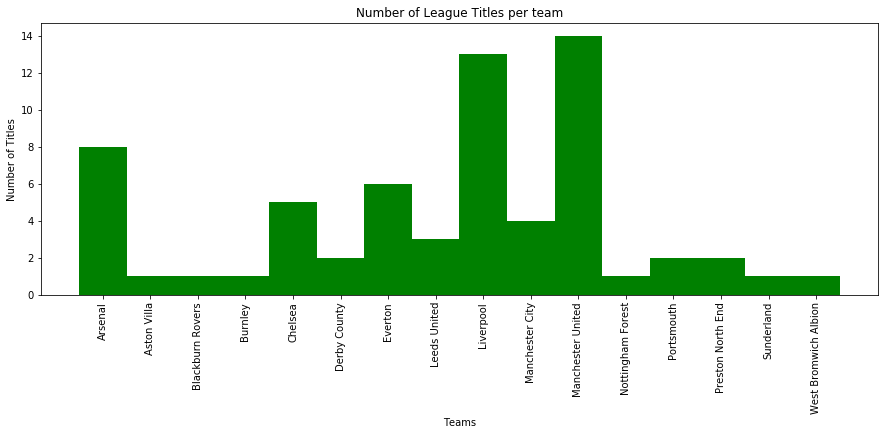

In [24]:
width = 1.0
plt.bar(winners_count.keys(), winners_count.values(), width, color='g')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Titles')
plt.xlabel('Teams')
plt.title("Number of League Titles per team")

## League Points

In [43]:
# Extract points per team
table_exist = lambda x: len(df["tables"][i]) > 0
teams_pts_tuples = [(row["Team"], row["Pts"]) for i in range(0, len(df["tables"])) if table_exist(i) for row in df["tables"][i][0]["tableRows"]]
teams = set([x[0] for x in teams_pts_tuples])
pts_per_team = dict([(team, sum(int(x[1]) for x in teams_pts_tuples if x[0] == team)) for team in teams])

In [55]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

Text(0.5,1,u'Number of league points per team')

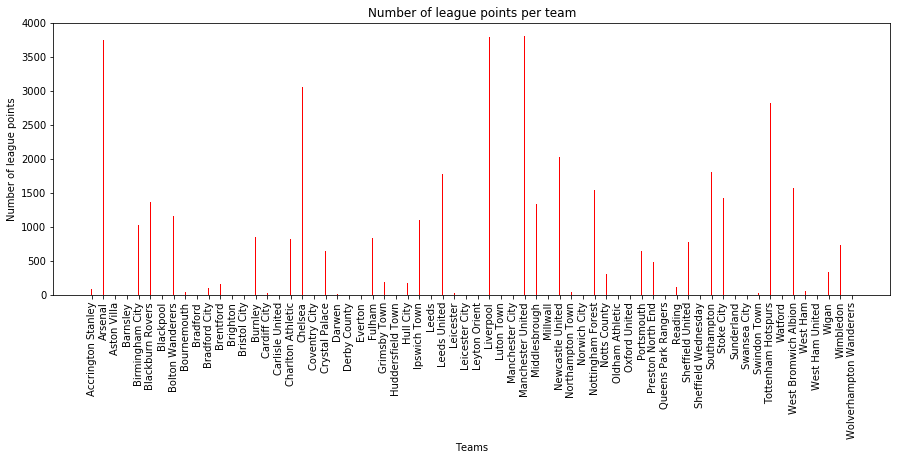

In [56]:
# Plot league pts per team
width = 0.05
plt.bar(pts_per_team.keys(),pts_per_team.values(), width, color='r')
plt.xticks(rotation='vertical')
plt.ylabel('Number of league points')
plt.xlabel('Teams')
plt.title("Number of league points per team")

## Points/Position Correlation

In [57]:
# Extract rows and pts
pts = [row["Pts"] for i in range(0, len(df["tables"])) if table_exist(i) for row in df["tables"][i][0]["tableRows"]]
pos = [row["Pos"] for i in range(0, len(df["tables"])) if table_exist(i) for row in df["tables"][i][0]["tableRows"]]

Text(0.5,1,u'Points/Position correlation')

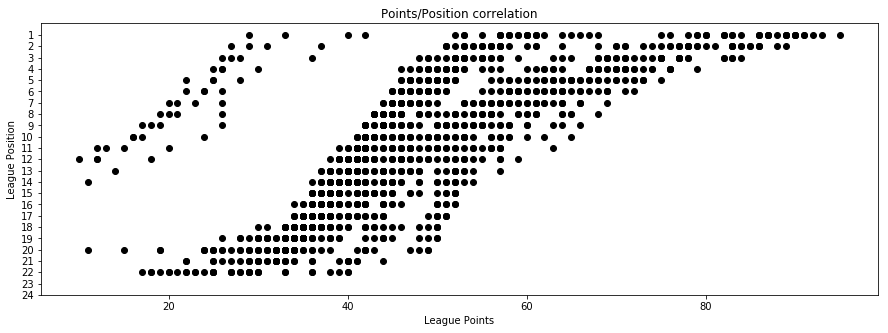

In [58]:
# plot pts and positions
plt.scatter(pts, pos, c='black')
plt.gca().invert_yaxis()
plt.ylabel('League Position')
plt.xlabel('League Points')
plt.yticks(np.arange(1,25))
plt.title("Points/Position correlation")

## League Position Prediction (Multi-Class Classification & Linear Regression)

### Dataset preparation

In [87]:
# Extract all teams
teams = list(set([row["Team"] for i in range(0, len(df["tables"])) if table_exist(i) for row in df["tables"][i][0]["tableRows"]]))
# Teams to Index Converter
teams_to_int = {team: i for i,team in zip(range(0, len(teams)), teams)}

In [88]:
temp = [([row["Pts"], row["A"], row["D"], row["F"], row["L"], row["P"], row["GD"], row["W"], teams_to_int[row["Team"]]], row["Pos"]) for i in range(0, len(df["tables"])) if table_exist(i) for row in df["tables"][i][0]["tableRows"]]
x,y = zip(*temp)
num_positions = len(set(y))

In [89]:
# one hot encode the labels for classification
y_class = map(lambda x: [1 if (j+1) == y[x] else 0 for j in range(0,num_positions)], y)

In [90]:
x = np.array(x)
y = np.array(y)
y_class = np.array(y_class)

In [91]:
x.shape

(1343, 9)

In [92]:
y.shape

(1343,)

In [93]:
y_class.shape

(1343, 22)

In [94]:
# Train/Test split 80/20
import random
indices = [i for i in range(0, len(y))]
random.shuffle(indices)
fraction = int(0.2*len(indices))
split_indices = indices[0:fraction]
train_x = [x[i] for i in range(0,len(x)) if i not in split_indices]
test_x = [x[i] for i in range(0,len(x)) if i in split_indices]
train_y = [y[i] for i in range(0,len(y)) if i not in split_indices]
test_y = [y[i] for i in range(0,len(y)) if i in split_indices ]
train_y_class = [y_class[i] for i in range(0,len(y)) if i not in split_indices]
test_y_class = [y_class[i] for i in range(0,len(y)) if i in split_indices ]

In [95]:
np.array(test_x).shape

(268, 9)

In [96]:
np.array(test_y).shape

(268,)

In [97]:
np.array(test_y_class).shape

(268, 22)

In [98]:
NUM_FEATURES = len(train_x[0])

In [109]:
import tensorflow as tf

In [110]:
def define_placeholders(class_flag):
    """ Define placeholders for inputs to the computational graph """
    input_x = tf.placeholder(tf.int32, [None, NUM_FEATURES], name="input_x")
    if class_flag:
        input_y = tf.placeholder(tf.int32, [None, num_positions], name="input_y")
    else:
        input_y = tf.placeholder(tf.int32, [None], name="input_y")
    return input_x, input_y

## Logit Computation in Softmax Regression

$$W_0 \in \mathbb{R}^{k \times \text{layer_width}}$$
$$x \in \mathbb{R}^{k}$$
$$b_i \in \mathbb{R}^{\text{layer_width}}$$
$$z_i \in \mathbb{R}^{\text{layer_width}}$$
$$a_i \in \mathbb{R}^{\text{layer_width}}$$
$$W_i \in \mathbb{R}^{\text{layer_width}\times \text{layer_width}}$$
$$W_n \in \mathbb{R}^{\text{layer_width}\times C}$$
$$logits \in \mathbb{R}^{C}$$
$$z_n \in \mathbb{R}^{C}$$
$$b_n \in \mathbb{R}^{C}$$
$$z_0 = W_0^Tx + b_0$$
$$a_0 = max(0, z_0)$$
$$\text{for} i \in \{0,...,\text{n_hidden_layers}\}$$
$$z_i = W_i^Ta_{i-1} + b_i$$
$$a_i = max(0, z_i)$$

## Linear Regression

$$W \in \mathbb{R}^{k \times 1}$$
$$x \in \mathbb{R}^k$$
$$b \in \mathbb{R}$$
$$z \in \mathbb{R}$$
$$z = W^Tx + b$$

In [188]:
def define_graph(input_x, n_hidden_layers, layer_width, dropout_keep_prob, class_flag):
    """Define the computational graph to compute everything except the loss"""
    # Softmax regression for multi-class classification
    if class_flag:
        # Input layer
        Wi = tf.Variable(tf.truncated_normal([NUM_FEATURES,layer_width], stddev=0.1), name="W0")
        bi = tf.Variable(tf.constant(0.1, shape=[layer_width]), name="b0")
        zi = tf.add(tf.matmul(tf.cast(input_x, tf.float32), Wi), bi)
        ai = tf.nn.relu(zi, name="a0")
        # N Hidden layers
        for i in range(1, n_hidden_layers):
            Wi = tf.Variable(tf.truncated_normal([layer_width,layer_width], stddev=0.1), name="W"+str(i))
            bi = tf.Variable(tf.constant(0.1, shape=[layer_width]), name="b" + str(i))
            zi = tf.add(tf.matmul(ai, Wi), bi)
            zi = tf.nn.dropout(zi, keep_prob=dropout_keep_prob)
            ai = tf.nn.relu(zi, name="a0")
        Wn = tf.Variable(tf.truncated_normal([layer_width,num_positions], stddev=0.1), name="W_out")
        bn = tf.Variable(tf.constant(0.1, shape=[num_positions]), name="b_out")
        zn = tf.add(tf.matmul(ai, Wn), bn)
        logits = tf.nn.relu(zn, name="logits")
        predictions = tf.argmax(logits,1)
    # Linear regression
    else:
        Wi = tf.Variable(tf.truncated_normal([NUM_FEATURES,1], stddev=0.1), name="W0")
        bi = tf.Variable(tf.constant(0.1, shape=[1]), name="b0")
        zi = tf.add(tf.matmul(tf.cast(input_x, tf.float32), Wi), bi)
        logits = zi
        predictions = logits
    return logits, predictions

In [185]:
def define_optimizer(logits, predictions, input_y, learning_rate, class_flag):
    """ Define optimizer for training"""
    if class_flag:
        # Define the loss, which is the loss between softmax of logits and the labels
        # Tensorflow performs softmax (the output activation) as part of the loss for efficiency
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y, logits=logits, name='xentropy_loss'))
        # Check element boolean equality
        correct_predictions = tf.equal(tf.cast(predictions,tf.int32), tf.cast(tf.argmax(input_y,1), tf.int32))
        # Accuracy = fraction of correct predictions
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_step = optimizer.minimize(loss)
        pass
    else:
        loss = tf.sqrt(tf.losses.mean_squared_error(tf.reshape(logits, [-1]), input_y))
        #tf.reshape(logits,[-1])
        total_error = tf.reduce_sum(tf.square(tf.subtract(input_y, tf.reduce_mean(input_y))))
        unexplained_error = tf.reduce_sum(tf.square(tf.subtract(tf.to_float(input_y), logits)))
        R_squared = tf.subtract(tf.to_float(1), tf.div(tf.to_float(unexplained_error), tf.to_float(total_error)))
        accuracy = R_squared
        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_step = optimizer.minimize(loss)
    return train_step, accuracy, loss

In [173]:
def init_graph():
    """
    initialize and run start operation
    """
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    return sess

In [174]:
def do_train(batch_x, batch_y, train_step, sess, input_x, input_y):
    """
    forward and back propagation of the graph, aka "learning"
    """
    sess.run(train_step, feed_dict={input_x:batch_x, input_y:batch_y})

In [175]:
def do_stats(batch_x, batch_y, accuracy, cross_entropy_loss, sess,input_x, input_y):
    """
    Compute training stats
    """
    accuracy, loss = sess.run([accuracy, cross_entropy_loss], feed_dict={input_x:batch_x, input_y:batch_y})
    return accuracy, loss

In [176]:
def shuffle(a, b):
    """ shuffle two arrays equally """
    indices = [i for i in range(0, len(a))]
    random.shuffle(indices)
    a = np.array([a[indices[i]] for i in range(0, len(a))])
    b = np.array([b[indices[i]] for i in range(0, len(b))])
    return a,b

In [177]:
def train(num_epochs, learning_rate, num_layers, layers_width, train_x, train_y, test_x, test_y, print_iter,batch_size, dropout_keep_prob, class_flag):
    """
    Code for orchestrating the training process
    """
    # get placeholders
    input_x, input_y = define_placeholders(class_flag)
    # get ops for training
    logits,predictions = define_graph(input_x, num_layers, layers_width, dropout_keep_prob, class_flag)
    train_step, accuracy, cross_entropy_loss = define_optimizer(logits, predictions, input_y, learning_rate, class_flag)
    # prepare for training
    sess = init_graph()
    total_iter = 0
    # training
    print("Starting training")
    for i in range(0, num_epochs):
        # shuffle training data
        train_x, train_y = shuffle(train_x, train_y)
        # split data into batches and do training with each batch
        for j in range(0, train_x.shape[0], batch_size):
            train_x_batch = train_x[j:j + batch_size]
            train_y_batch = train_y[j:j + batch_size]
            do_train(train_x_batch, train_y_batch, train_step, sess, input_x, input_y)
            if(total_iter % print_iter == 0):
                train_acc, train_loss = do_stats(train_x_batch, train_y_batch, accuracy, cross_entropy_loss, sess,input_x, input_y)
                test_acc, test_loss = do_stats(test_x, test_y, accuracy, cross_entropy_loss, sess,input_x, input_y)
                print("Iteration {}, current epoch {}".format(total_iter, i))
                if class_flag:
                    print("train accuracy: {}, train loss: {}".format(train_acc, train_loss))
                    print("test accuracy: {}, test loss: {}".format(test_acc, test_loss))
                else:
                    print("train R^2: {}, train loss: {}".format(train_acc, train_loss))
                    print("test R^2: {}, test loss: {}".format(test_acc, test_loss))
            total_iter += 1

In [189]:
# Softmax regression
train(10000, 0.001, 4, 64, train_x, train_y_class, test_x, test_y_class, 1000, 512, 0.8, True)

# Linear regression
#train(10000, 0.001, 1, 64, train_x, train_y, test_x, test_y, 1000, 512, 1, False)

Starting training
Iteration 0, current epoch 0
train accuracy: 0.041015625, train loss: 3.1434366703
test accuracy: 0.0335820913315, test loss: 3.14583110809
Iteration 1000, current epoch 333
train accuracy: 0.31640625, train loss: 1.75382626057
test accuracy: 0.24626865983, test loss: 1.98090994358
Iteration 2000, current epoch 666
train accuracy: 0.254901975393, train loss: 1.84117519855
test accuracy: 0.25746268034, test loss: 1.97563827038
Iteration 3000, current epoch 1000
train accuracy: 0.439453125, train loss: 1.4565372467
test accuracy: 0.25373134017, test loss: 2.15235471725
Iteration 4000, current epoch 1333
train accuracy: 0.447265625, train loss: 1.43071329594
test accuracy: 0.26492536068, test loss: 2.16748404503
Iteration 5000, current epoch 1666
train accuracy: 0.372549027205, train loss: 1.45380437374
test accuracy: 0.238805964589, test loss: 2.491989851
Iteration 6000, current epoch 2000
train accuracy: 0.466796875, train loss: 1.36972439289
test accuracy: 0.246268659